In [ ]:
from tensorflow.keras import Sequential, layers, utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

STANDARD_IMAGE_SIZE = 64

number_to_label = {
    1: "palm",
    2: "l",
    3: "fist",
    4: "fist_moved",
    5: "thumb",
    6: "index",
    7: "ok",
    8: "palm_moved",
    9: "c",
    10: "down"
}

In [165]:
# Data preprocessing step
GAUSSIAN_BLUR_SIZE = 5
CANNY_THRESHOLD_1 = 50
CANNY_THRESHOLD_2 = 100

PATH = "data/"

def preProcessImage(image):
    '''
    * Shrink
    * Grey Scale
    * Gaussian Blur
    * Edge Detection
    * Normalization
    '''
    img = cv2.resize(image, (STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (GAUSSIAN_BLUR_SIZE, GAUSSIAN_BLUR_SIZE), 0)
    img = cv2.Canny(img, CANNY_THRESHOLD_1, CANNY_THRESHOLD_2)
    img = img / 255.0
    return img

def preProcessData():
    data = []
    for i in range(0, 10):
        data.append([])    

    for i in range(0, 10):
        for j in range(1,11):
            second_value = str(j) if j >= 10 else '0' + str(j)
            current_path = PATH + '0' + str(i) + "/" + second_value + "_" + number_to_label[j]

            for image in os.listdir(current_path):
                img = cv2.imread(current_path + "/" + image)
                img = preProcessImage(img)
                data[j-1].append(img)
    return data

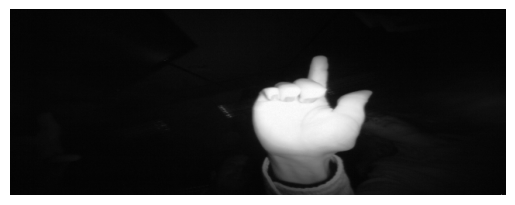

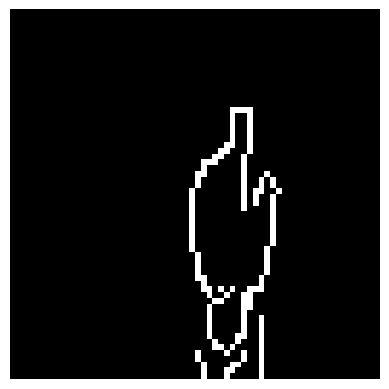

In [166]:
# Before and after preprocessing
image = cv2.imread("data/00/02_l/frame_00_02_0002.png")
plt.imshow(image)
plt.axis("off")
plt.show()

image = preProcessImage(image)
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

In [167]:
data = preProcessData()

# Feature Extraction
for i, v in enumerate(data):
    for j, w in enumerate(v):
        data[i][j] = np.array(w.tolist())

# Split the data into train, validate, and test
train_data = []
validate_data = []
test_data = []

for i, v in enumerate(data):
    np.random.shuffle(v)
    train = int(len(v) * 0.8)
    validate = train + int(len(v) * 0.1)
    
    train_data.extend((w, i) for w in v[:train])
    validate_data.extend((w, i) for w in v[train:validate])
    test_data.extend((w, i) for w in v[validate:])

np.random.shuffle(train_data)
np.random.shuffle(validate_data)
np.random.shuffle(test_data)

# One-hot encoding the labels
train_labels = utils.to_categorical(np.array([i[1] for i in train_data]), num_classes=10)
validate_labels = utils.to_categorical(np.array([i[1] for i in validate_data]), num_classes=10)
test_labels = utils.to_categorical(np.array([i[1] for i in test_data]), num_classes=10)

train_data = np.array([i[0] for i in train_data])
validate_data = np.array([i[0] for i in validate_data])
test_data = np.array([i[0] for i in test_data])

In [168]:
# Convolutional Neural Network
CNN_KERNEL = 3
CNN_FILTERS = 32
CNN_POOL_SIZE = 2

model_cnn = Sequential()

# Feature Extraction
model_cnn.add(layers.Input(shape=(STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE, 1)))
model_cnn.add(layers.Conv2D(CNN_FILTERS, (CNN_KERNEL, CNN_KERNEL), activation="relu"))
model_cnn.add(layers.MaxPooling2D(pool_size=(CNN_POOL_SIZE, CNN_POOL_SIZE)))

model_cnn.add(layers.Conv2D(CNN_FILTERS * 2, (CNN_KERNEL, CNN_KERNEL), activation="relu"))
model_cnn.add(layers.MaxPooling2D(pool_size=(CNN_POOL_SIZE, CNN_POOL_SIZE)))

model_cnn.add(layers.Conv2D(CNN_FILTERS*2, (CNN_KERNEL, CNN_KERNEL), activation="relu"))
model_cnn.add(layers.MaxPooling2D((CNN_POOL_SIZE, CNN_POOL_SIZE)))

# Classification
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(CNN_FILTERS*4, activation="relu"))
model_cnn.add(layers.Dense(10, activation="softmax"))

model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        "precision",
        "recall",
    ]
)

In [169]:
# Training and Evaluation
history_cnn = model_cnn.fit(train_data[:120], train_labels[:120], epochs=30, 
                    validation_data=(validate_data[:40], validate_labels[:40]),
                    verbose=2)

result_cnn = model_cnn.evaluate(test_data,  test_labels, verbose=2)
test_prediction_cnn = model_cnn.predict(test_data)

Epoch 1/30
4/4 - 6s - 1s/step - accuracy: 0.1917 - loss: 2.2729 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1750 - val_loss: 2.2284 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
4/4 - 0s - 51ms/step - accuracy: 0.2167 - loss: 2.0803 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2750 - val_loss: 2.1289 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
4/4 - 0s - 14ms/step - accuracy: 0.4167 - loss: 1.7474 - precision: 1.0000 - recall: 0.0250 - val_accuracy: 0.5250 - val_loss: 1.8372 - val_precision: 0.3333 - val_recall: 0.0250
Epoch 4/30
4/4 - 0s - 14ms/step - accuracy: 0.6167 - loss: 1.3262 - precision: 0.7941 - recall: 0.2250 - val_accuracy: 0.5250 - val_loss: 1.8522 - val_precision: 0.8125 - val_recall: 0.3250
Epoch 5/30
4/4 - 0s - 19ms/step - accuracy: 0.7000 - loss: 0.9624 - precision: 0.8947 - recall: 0.5667 - val_accuracy: 0.5750 - val_loss: 1.7942 - val_precision: 0.6552 - val_recall: 0.4750
Epoch 6/30
4/4 - 0s 

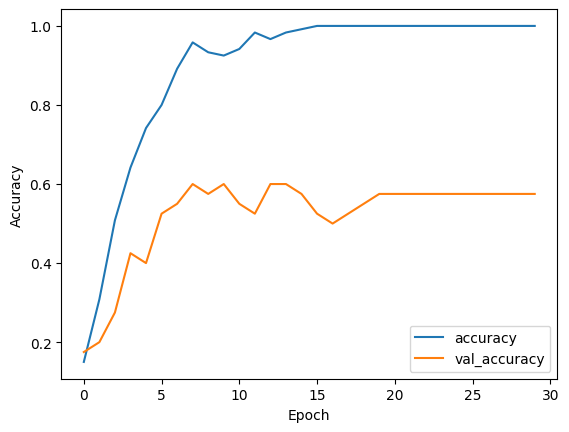

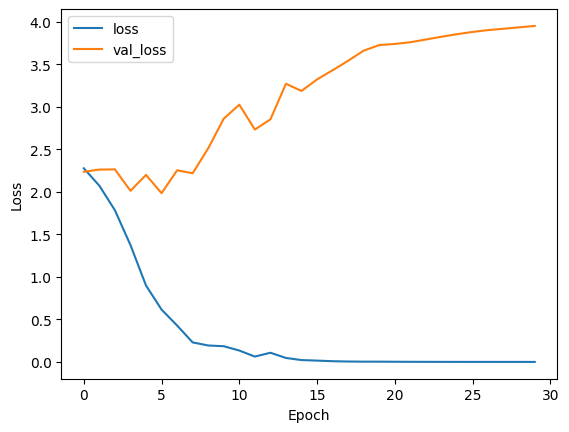

Test Loss:  3.109323501586914
Test Accuracy:  0.6489999890327454
Test Precision:  0.6561224460601807
Test Recall:  0.6430000066757202
Test F1 Score:  0.6494949514702161


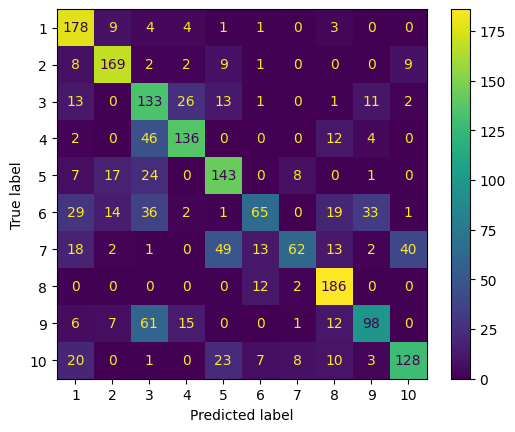

In [163]:
#plotting and printing results
plt.plot(history_cnn.history["accuracy"], label="accuracy")
plt.plot(history_cnn.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_cnn.history["loss"], label="loss")
plt.plot(history_cnn.history["val_loss"], label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Test Loss: ", result_cnn[0])
print("Test Accuracy: ", result_cnn[1])
print("Test Precision: ", result_cnn[2])
print("Test Recall: ", result_cnn[3])
print("Test F1 Score: ", 2 * (result_cnn[2] * result_cnn[3]) / (result_cnn[2] + result_cnn[3]))

confusion = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(test_prediction_cnn, axis=1))
ConfusionMatrixDisplay(confusion, display_labels=[i for i in range(1,11)]).plot()